# Snowfall Retrievals CSU X-Band Radar March 14, 2022
Let's take a look at precipitation from an event on March 14, 2022 as a part of the SAIL field campaign.

## Imports

In [408]:
import glob
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pyart
import xarray as xr
from matplotlib.dates import DateFormatter
import pandas as pd

## Setup Helper Functions
We setup helper functions to calculate the snowfall retrieval, using following notation:

$Z = A*S ^ {B}$

Where:
- Z = Reflectivity in dBZ
- A = Coefficient applied to Z-S Relationship (not in the exponent)
- S = Liquid snowfall rate
- B = Coefficient applied to Z-S Relationship (in the exponent)

We also need to apply a snow water equivalent ratio (`swe`) to convert from liquid to snow (ex. 8 inches of snow --> 1 inch of rain would be 8.0).

This equation now becomes:

$Z = swe*A*S ^ {B}$

Solving for S, we get:

$S = swe * (\frac{z}{a})^{1/B}$

Where z is reflectivity in units of dB ($z =10^{Z/10}$)

In [409]:
def snow_rate(radar, swe_ratio, A, B):
    """
    Snow rate applied to a pyart.Radar object
    
    Takes a given Snow Water Equivilent ratio (swe_ratio), A and B value
    for the Z-S relationship and creates a radar field similar to DBZ
    showing the radar estimated snowfall rate in mm/hr. Then the given
    SWE_ratio, A and B are stored in the radar metadata for later 
    reference.

    """
    # Setting up for Z-S relationship:
    snow_z = radar.fields['DBZ']['data'].copy()
    # Convert it from dB to linear units
    z_lin = 10.0**(radar.fields['DBZ']['data']/10.)
    # Apply the Z-S relation.
    snow_z = swe_ratio * (z_lin/A)**(1./B)
    # Add the field back to the radar. Use reflectivity as a template
    radar.add_field_like('DBZ', 'snow_z',  snow_z,
                         replace_existing=True)
    # Update units and metadata
    radar.fields['snow_z']['units'] = 'mm/h'
    radar.fields['snow_z']['standard_name'] = 'snowfall_rate'
    radar.fields['snow_z']['long_name'] = 'snowfall_rate_from_z'
    radar.fields['snow_z']['valid_min'] = 0
    radar.fields['snow_z']['valid_max'] = 500
    radar.fields['snow_z']['swe_ratio'] = swe_ratio
    radar.fields['snow_z']['A'] = A
    radar.fields['snow_z']['B'] = B
    return radar

In [211]:
def snow_rate_from_ds(ds, swe_ratio, A, B, snow_field_name="snow_z", reflectivity_field='DBZ'):
    """
    Snow rate applied to an Xarray.Dataset
    
    Takes a given Snow Water Equivilent ratio (SWE_ratio), A and B value
    for the Z-S relationship and creates a radar field similar to DBZ
    showing the radar estimated snowfall rate in mm/hr. Then the given
    SWE_ratio, A and B are stored in the radar metadata for later 
    reference.   
    """
    snow_z = ds[reflectivity_field].copy()
    
    # Convert it from dB to linear units
    z_lin = 10.0**(snow_z/10.)
    
    # Apply the Z-S relation.
    snow_z = swe_ratio * (z_lin/A)**(1./B)
    
    ds[snow_field_name] = snow_z
    
    field_attrs = {"units": "mm/h",
                   "standard_name": "snowfall_rate",
                   "long_name":"snowfall_rate_from_z",
                   "valid_min":0,
                   "valid_max":500,
                   "swe_ratio":swe_ratio,
                   "A":A,
                   "B":B}
    
    ds[snow_field_name].attrs = field_attrs
    
    return ds


## Define the Point Retrievals
We need to create a set of latitude and longitude values for the different instrumentation locations.

In [15]:
# Define the splash locations [lon,lat]
sail = [-106.987, 38.9586]
kettle_ponds = [-106.9731488, 38.9415427]
brush_creek = [-106.920259, 38.8596282]
avery_point = [-106.9965928, 38.9705885]
pumphouse_site = [-106.9502476, 38.9226741]
roaring_judy = [-106.8530215, 38.7170576]
pluvio = [-106.986, 38.9565]

sites = ["sail", "kettle_ponds", "brush_creek", "avery_point", "pumphouse_site", "roaring_judy", "pluvio"]

# Zip these together!
lons, lats = list(zip(sail,
                      kettle_ponds,
                      brush_creek,
                      avery_point,
                      pumphouse_site,
                      roaring_judy,
                      pluvio))

## List the Available Files
We will use files on the Oak Ridge Laboratory Computing Facility (ORLCF), within the shared SAIL directory `/gpfs/wolf/atm124/proj-shared/sail`.

These radar files have been merged from a single sweep in each file, to whole volume scans in each file.

In [5]:
file_list = sorted(glob.glob("/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314*"))
file_list[:10]

['/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-000239.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-000759.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-001319.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-001839.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-002359.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-002919.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-003439.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-003959.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-004519.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-005039.b1.nc']

## Read Data + Subset at Points

In [12]:
def process_point(files, lat, lon):
    """Process data for a single point"""
    ds_all = []
    for file in file_list:
        radar = pyart.io.read(file)
        #-------------------------------------------------------------------------
        # Add in the extra fields to the radar object before extracting the column
        #-------------------------------------------------------------------------
        # Calculate estimated rainfall rate from reflectivty
        #rain = pyart.retrieve.qpe.est_rain_rate_z(radar)
        # Add the estimated rainfall rate back into the radar object
        #radar.add_field('est_rainfall_rate', rain)
        # Call Matt's Z-S function with the constants he used
        radar = snow_rate(radar, 8.5, 28, 1.44)
        #-------------------------------------------------------------------------
        column = pyart.util.columnsect.get_field_location(radar, avery_point[1], avery_point[0])
        # Add a datetime dimension to the xarray radar column
        dt = pd.to_datetime(radar.time["data"], unit='s')[-1]
        coor_ad = column.assign_coords(date=dt.timestamp())
        ncolumn = coor_ad.expand_dims('date')
        # Make sure there are no duplicate height indices
        index = np.unique(column['height'], return_index=True)
        ncolumn = ncolumn.isel(height=index[1])
        # append to the xarray dataset list
        ds_all.append(ncolumn)
    
    # Combine the xarry DataArrays
    ds = xr.concat(ds_all, 'date')
    
    # Correct the datetimes
    ds["date"] = pd.to_datetime(ds.date.values, unit='s')
    
    return ds

In [182]:
def subset_points(file, lats, lons, sites):
    """Subset a radar file for a set of latitudes and longitudes"""
    
    # Read in the file
    radar = pyart.io.read(file)
    
    column_list = []
    for lat, lon in zip(lats, lons):
        da = pyart.util.columnsect.get_field_location(radar, lat, lon).interp(height=np.arange(100, 2600, 100))
        da["latitude"], da["longitude"] = lat, lon
        dt = pd.to_datetime(radar.time["data"], unit='s')[-1]
        da.expand_dims("time")
        da["time"] = [dt]
        # Make sure there are no duplicate height indices
        index = np.unique(da['height'], return_index=True)
        ncolumn = da.isel(height=index[1]).dropna(dim='height')
        column_list.append(ncolumn)
        
    ds = xr.concat(column_list, dim='site')
    ds["site"] = sites
    return ds

### Loop through and subset the radar fields at the given points

In [183]:
%%time
ds_list = []
for file in file_list[:200]:
    ds_list.append(subset_points(file, lats, lons, sites))

/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/pyart/core/transforms.py:177: UserWarning: dot_product is larger than one.
  warnings.warn("dot_product is larger than one.")


CPU times: user 9min 25s, sys: 43.9 s, total: 10min 9s
Wall time: 11min 56s


#### Merge the datasets at the end across time

In [184]:
ds = xr.concat(ds_list, dim='time')

## Apply our Z-S Relationships

## Plot Reflectivity at Each Site
We loop through and plot reflectivity above each site.

### Define our Z-S Relationships

We start by using the Z-S Relationships Described in [Bukovčić et al. (2018)](https://doi.org/10.1175/JAMC-D-17-0090.1), where we refer to following relationships in Table 1:

| Source                      | Z(S) relation for dry snow | A Coefficient | B Coefficient |
| :---                        |           :----:           |          ---: | :---------:   |
| Wolfe and Snider (2012)     | $Z = {110}S^{2}$           | 110           |  2            |
| WSR-88D high plains         | $Z = {130}S^{2}$           | 130           |  2            |
| WSR-88D Intermountain West  | $Z = {40}S^{2}$            | 40            |  2            |

We can plug these into a dictionary for safe keeping.

In [256]:
zs_relationship_dict = {"Wolf_and_Snider":
                        {"A": 110,
                         "B": 2},
                        "WSR_88D_High_Plains":
                        {"A": 130,
                         "B": 2},
                        "WSR_88D_Intermountain_West":
                        {"A": 40,
                         "B": 2}
                       }

### Apply our Z(S) Relationships to the Dataset
Once we have our dictionary from above, we can apply it to our dataset, using a constant value of a snow liquid water equivalent of 8.5

In [ ]:
for relationship in zs_relationship_dict.keys():
    snow_rate_from_ds(ds,
                      8.5,
                      zs_relationship_dict[relationship]["A"],
                      zs_relationship_dict[relationship]["B"],
                      snow_field_name=relationship)

## Reflectivity with Height at Each Site

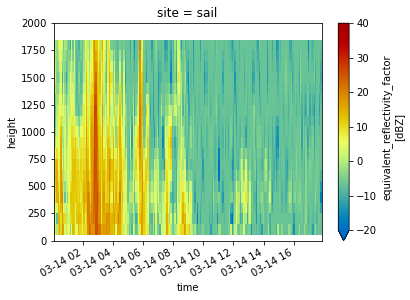

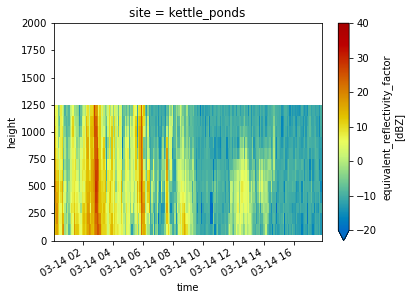

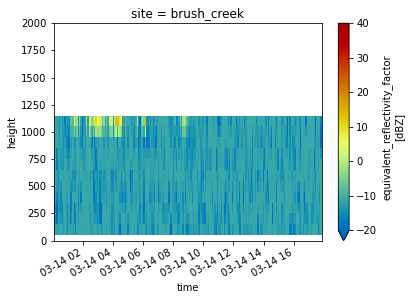

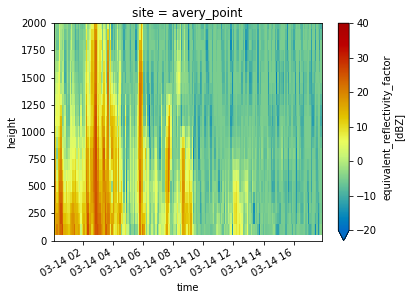

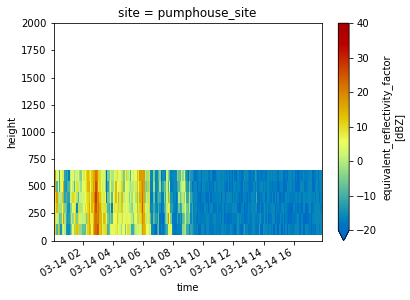

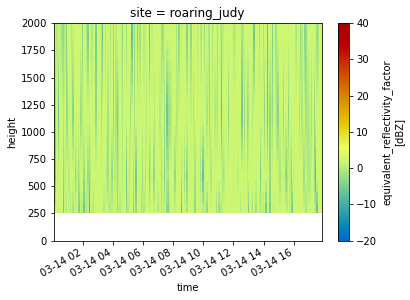

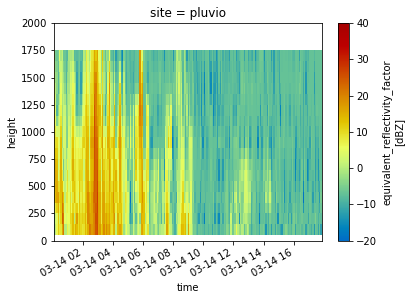

In [410]:
for site in ds.site:
    ds.sel(site=site).DBZ.plot(x='time',
                             cmap='pyart_HomeyerRainbow',
                             vmin=-20,
                             vmax=40)
    plt.ylim(0, 2000)
    plt.show()
    plt.close()

## Look at a Timeseries of Snowfall Rates and Totals

Text(0.5, 0.98, 'Estimated Snowfall Rates from X-Band Radar \n SAIL Domain 14 March 2022')

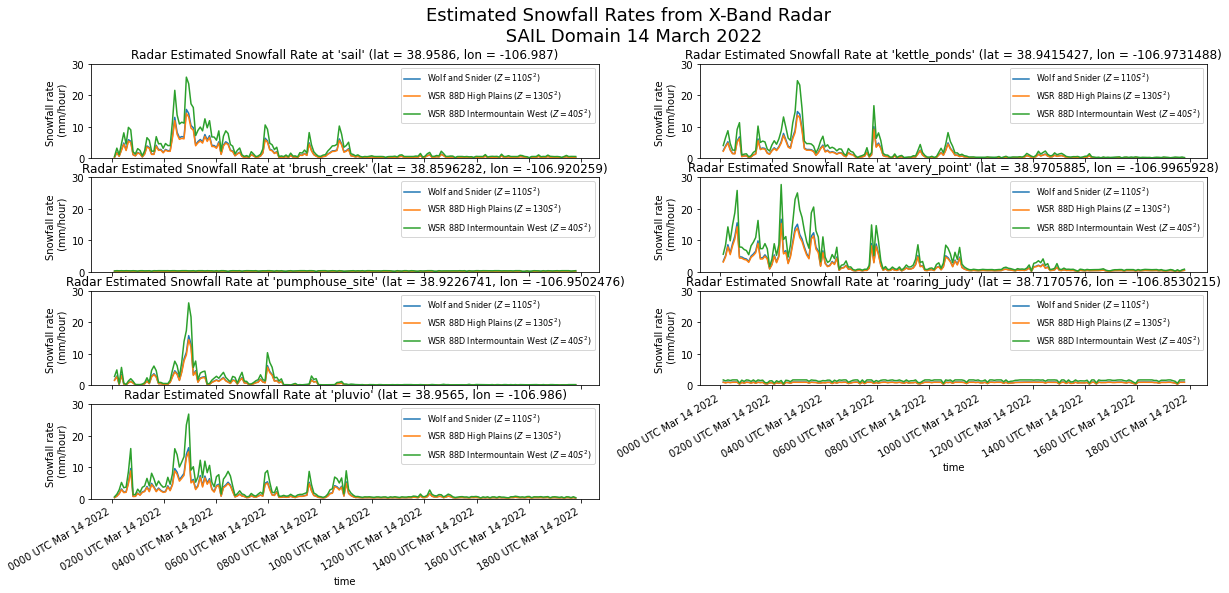

In [400]:
date_form = DateFormatter("%H%M UTC %b %d %Y")
min_value = 0
max_value = 30

fig = plt.figure(figsize=(20,8))

for site in range(len(ds.site.values)):
    ds_at_site = ds.isel(site=site).dropna(dim='height')
    site_name = ds_at_site.site.values
    ax=plt.subplot(int(f"42{site+1}"))
    for relationship in zs_relationship_dict.keys():
        relationship_name = relationship.replace("_", " ")
        a_coefficeint = ds[relationship].A
        b_coefficeint = ds[relationship].B
        relationship_equation = f"$Z = {a_coefficeint}S^{b_coefficeint}$"
        
        ds_at_site.isel(height=0)[relationship].plot(label=f'{relationship_name} ({relationship_equation})',
                                                     ax=ax)
        ax.xaxis.set_major_formatter(date_form)
        plt.legend(fontsize=8, loc='upper right')
        
    plt.title(f"Radar Estimated Snowfall Rate at '{site_name}' (lat = {ds_at_site.latitude.values[0]}, lon = {ds_at_site.longitude.values[0]})")

for ax in fig.axes[:-2]:
    ax.axes.axis("tight")
    ax.axes.get_xaxis().set_ticklabels([])
    ax.set_ylabel("Snowfall rate \n (mm/hour)")
    ax.set_xlabel("")
    ax.set_ylim(min_value, max_value)

for ax in fig.axes[-2:]:
    ax.axes.axis("tight")
    ax.set_ylabel("Snowfall rate \n (mm/hour)")
    ax.set_ylim(min_value, max_value)
    
plt.suptitle("Estimated Snowfall Rates from X-Band Radar \n SAIL Domain 14 March 2022", fontsize=18)

Text(0.5, 0.98, 'Estimated Cumulative Snowfall Totals from X-Band Radar \n SAIL Domain 14 March 2022')

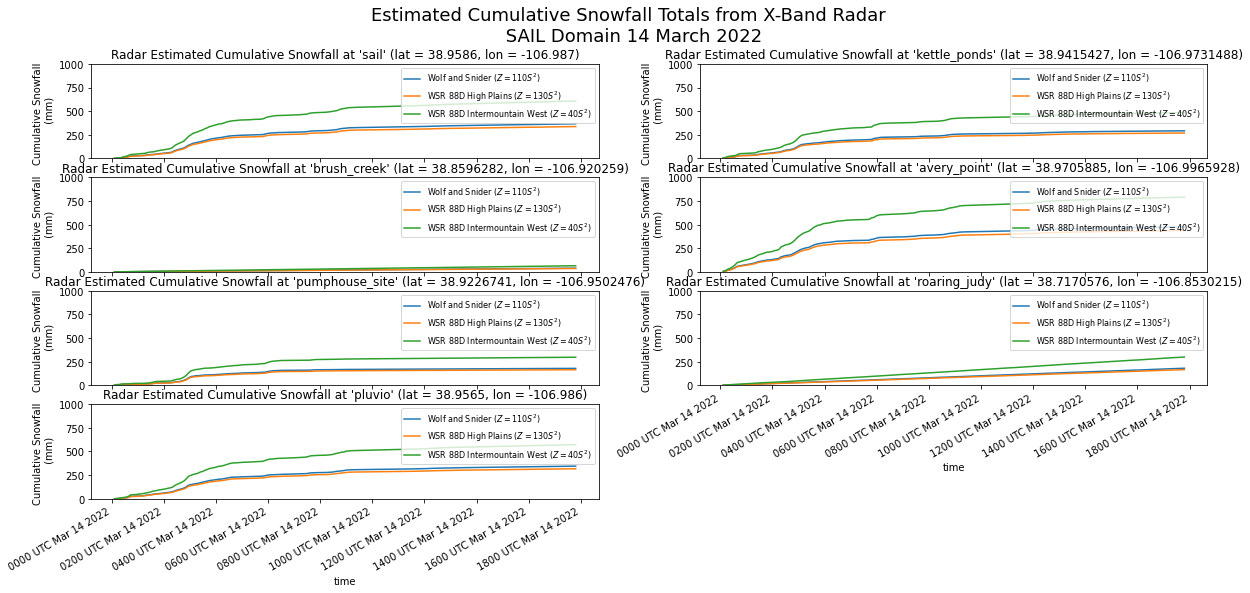

In [407]:
date_form = DateFormatter("%H%M UTC %b %d %Y")
min_value = 0
max_value = 1000

fig = plt.figure(figsize=(20,8))

for site in range(len(ds.site.values)):
    ds_at_site = ds.isel(site=site).dropna(dim='height')
    site_name = ds_at_site.site.values
    ax=plt.subplot(int(f"42{site+1}"))
    for relationship in zs_relationship_dict.keys():
        relationship_name = relationship.replace("_", " ")
        a_coefficeint = ds[relationship].A
        b_coefficeint = ds[relationship].B
        relationship_equation = f"$Z = {a_coefficeint}S^{b_coefficeint}$"
        
        ds_at_site.isel(height=0)[relationship].cumsum("time").plot(label=f'{relationship_name} ({relationship_equation})',
                                                                    ax=ax)
        plt.ylim(min_value, max_value)
        ax.xaxis.set_major_formatter(date_form)
        plt.legend(fontsize=8, loc='upper right')
        
    plt.title(f"Radar Estimated Cumulative Snowfall at '{site_name}' (lat = {ds_at_site.latitude.values[0]}, lon = {ds_at_site.longitude.values[0]})")

for ax in fig.axes[:-2]:
    ax.axes.axis("tight")
    ax.axes.get_xaxis().set_ticklabels([])
    ax.set_ylabel("Cumulative Snowfall \n (mm)")
    ax.set_xlabel("")
    ax.set_ylim(min_value, max_value)

for ax in fig.axes[-2:]:
    ax.axes.axis("tight")
    ax.set_ylabel("Cumulative Snowfall \n (mm)")
    ax.set_ylim(min_value, max_value)
    
plt.suptitle("Estimated Cumulative Snowfall Totals from X-Band Radar \n SAIL Domain 14 March 2022", fontsize=18)

In [383]:
ds.to_netcdf("sail_snowfall_retrievals_march_14_2022.nc")